In [1]:
%matplotlib inline
import os, sys
%run prelims
import opc_python
import numpy as np
import matplotlib.pyplot as plt
import pandas
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,fit1,fit2,params

In [218]:
perceptual_headers, perceptual_obs_data = loading.load_perceptual_data('training')
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
#mdx = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx = dream.get_molecular_data(['dragon','episuite','morgan'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
There are now 7369 total features.


### Create matrices

In [219]:
X_all,good1,good2,means,stds,imputer = dream.make_X(mdx,['training','leaderboard'])
Y_all_mask,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')
Y_all_imp,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='median')
X_gs,good1,good2,means,stds,imputer = dream.make_X(mdx,['testset'],good1=good1,good2=good2,means=means,stds=stds,target_dilution='gold')
Y_gs,imputer = dream.make_Y_obs(['testset'],target_dilution='gold',imputer='mask')

The X matrix now has shape (814x5553) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject
The X matrix now has shape (69x5553) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (69x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (69x21) molecules by perceptual descriptors, one for each subject


In [220]:
# Load optimal parameters (obtained from extensive cross-validation).
cols = range(42)
def get_params(i):
    return {col:params.best[col][i] for col in cols}

use_et = get_params(0)
max_features = get_params(1)
max_depth = get_params(2)
min_samples_leaf = get_params(3)
trans_weight = get_params(4)
regularize = get_params(4)
use_mask = get_params(5)
for col in range(21):
    trans_weight[col] = trans_weight[col+21]

In [221]:
"""
from sklearn.cross_validation import ShuffleSplit
n_obs = int(len(Y_all_mask['subject'][1][:,col])/2)
n_splits = 3
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.2,random_state=0)
rs = np.zeros((21,49,n_splits))

X = X_all
Y_imp = Y_all_imp['subject']
Y_mask = Y_all_mask['subject']
for k,(train,test) in enumerate(shuffle_split):
    print(k, flush=True)
    train = np.concatenate((2*train,2*train+1))
    test = np.concatenate((2*test,2*test+1))
    
    Y_train = {i:Y_imp[i][train] for i in range(1,50)}
    Y_test = {i:Y_mask[i][test] for i in range(1,50)}
    rfcs_cv,_,_ = fit1.rfc_final(X[train],Y_train,
                                 max_features,min_samples_leaf,max_depth,use_et,
                                 regularize=regularize,n_estimators=5)
    Y_cv = loading.make_prediction_files(rfcs_cv,X[test],X[test],
                                 'all',1,Y_test=None,
                                  write=False,regularize=regularize)
    for col in range(21):
        for subject in range(1,50):
            rs[col,subject-1,k] = np.ma.corrcoef(Y_cv['subject'][subject][:,col],
                                   Y_test[subject][:,col])[0,1]
print(rs.mean(axis=1))
""";

In [ ]:
X_train = X_all
Y_train = Y_all_imp['subject']

In [222]:
#rfcs,_,_ = fit1.rfc_final(X_train,Y_train,
#                             max_features,min_samples_leaf,max_depth,use_et,
#                             regularize=regularize,n_estimators=25)
#import pickle
#with open('../../data/rfcs_1.pickle','wb') as f:
#    pickle.dump(rfcs,f,protocol=3)
with open('../../data/rfcs_1.pickle','rb') as f:
    rfcs = pickle.load(f,protocol=3)

98.00% [------------------------------------------------- ]For subchallenge 1:
	Score = 36.52
	int = 0.841
	ple = 0.395
	dec = 0.177


In [223]:
Y_pred = loading.make_prediction_files(rfcs,X_gs,X_gs,
                                     'all',1,Y_test=None,
                                      write=False,regularize=[0.8]*21)

In [224]:
y_gs = np.ma.dstack([Y_gs['subject'][i] for i in range(1,50)])
y_pred = np.ma.dstack([Y_pred['subject'][i] for i in range(1,50)])
rs_gs = np.ma.zeros((21,49))
coe_gs = np.zeros((21,49))
for col in range(21):
    for subject in range(49):
        o = y_gs[:,col,subject].copy()
        p = y_pred[:,col,subject].copy()
        rs_gs[col,subject] = np.ma.corrcoef(o,p)[0,1]
        x = (o - p).compressed()
        sse = (x**2).mean()# - x.mean()**2
        coe_gs[col,subject] = np.sqrt(sse.mean())# / p.mean()
#np.save('../../data/sc1_all_rs.npy',rs_gs.data)
#np.save('../../data/sc1_all_coes.npy',coe_gs)

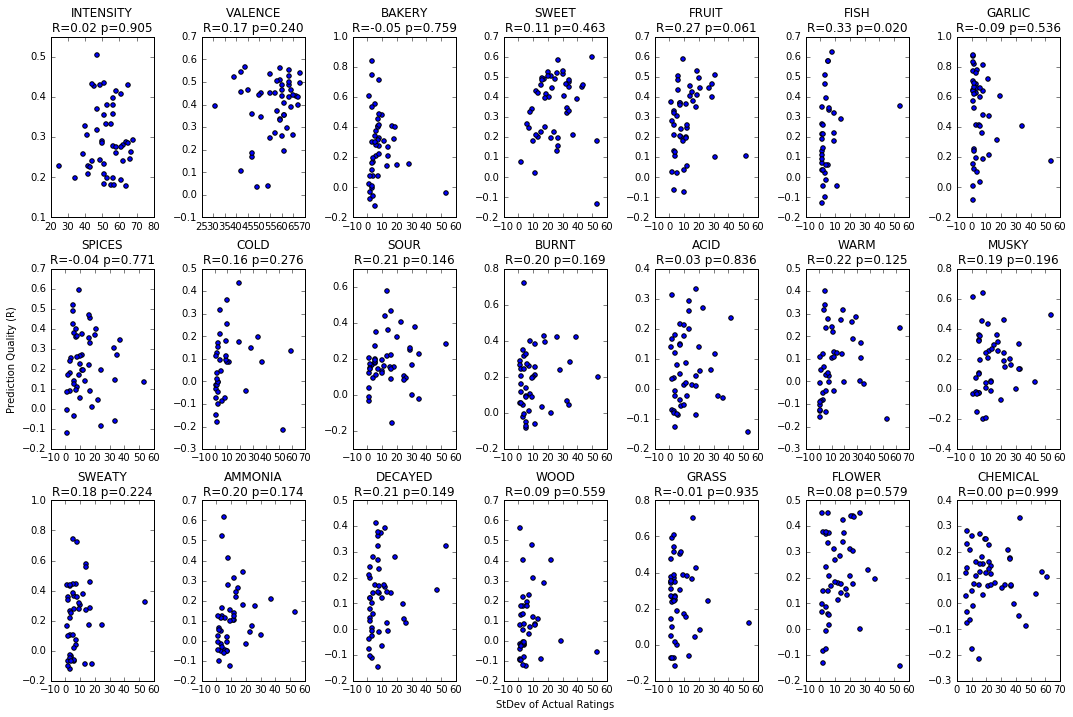

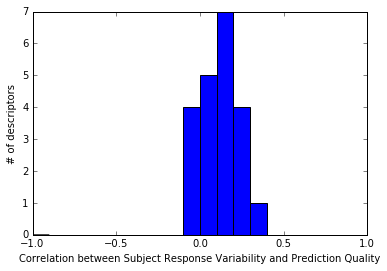

In [217]:
from scipy.stats import linregress
data = loading.load_data_matrix(gold_standard_only=True, only_replicates=True)
#coe_gs = np.load('../../data/sc1_all_coes.npy')
fig,axes = plt.subplots(3,7,figsize=(15,10))
rs = np.zeros(21)
ps = np.zeros(21)
for i,ax in enumerate(axes.flat):
    dil = 1 if i==0 else slice(None)
    o = data[:,:,i,dil,0]
    r = data[:,:,i,dil,1]
    if len(o.shape)==3:
        o = o.mean(axis=2) # Collapse the dilution dimension
        r = r.mean(axis=2) # Collapse the dilution dimension
    trt_var = np.zeros(49)
    for j in range(49):
        x = (r[j,:] - o[j,:]).compressed()
        trt_var[j] = x.var()#(x**2).mean() - x.mean()**2
    #val = np.ma.array(y_pred[:,i,:].mean(axis=0)*np.tan(np.arccos(rs_gs[i,:])),mask=np.isnan(rs_gs[i,:]))
    val = rs_gs[i,:]
    x = np.sqrt(y_gs[:,i,:].var(axis=0))# - trt_var)# / y_pred[:,i,:].mean(axis=0)
    ax.scatter(x,val)
    xmax = max(x.max(),val.max())*1.1
    #ax.plot([0,xmax],[0,xmax],'--',color='k')
    _,_,rs[i],ps[i],_ = linregress(x,val)
    ax.set_title('%s\nR=%.2f p=%.3f' % (descriptors[i].split('/')[0],rs[i],ps[i]))
    if i==7:
        ax.set_ylabel('Prediction Quality (R)')
    if i==17:
        ax.set_xlabel('StDev of Actual Ratings')

plt.tight_layout()
plt.figure()
#print(rs)
plt.hist(rs,bins=np.linspace(-1,1,21))
plt.xlabel('Correlation between Subject Response Variability and Prediction Quality')
plt.ylabel('# of descriptors')
        
#plt.tight_layout()

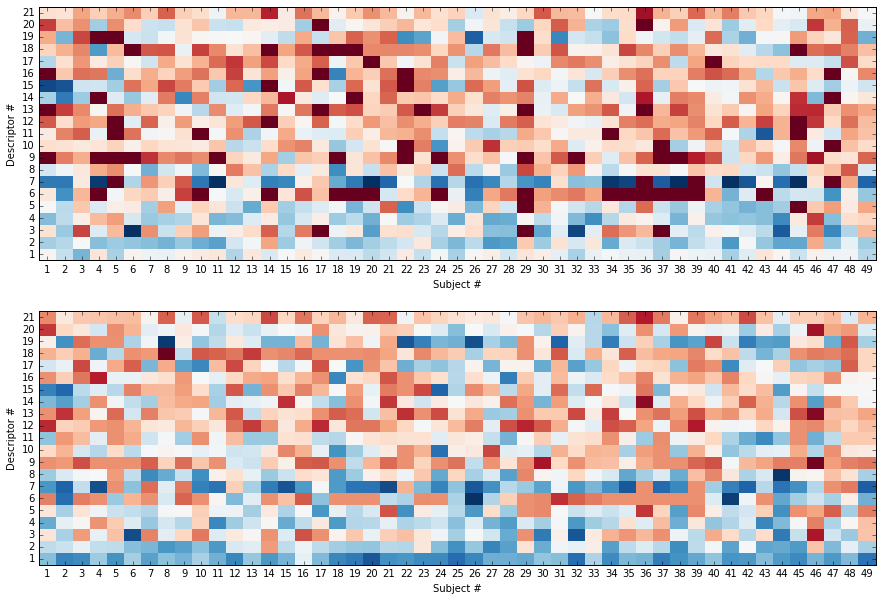

In [146]:
from scipy.io import matlab
yg = matlab.loadmat('../../data/sc2_yg.mat')
yg = yg['a2']
resort = [sorted([str(i) for i in range(1,50)]).index(str(s)) for s in range(1,50)]
yg = yg[:,resort]

fig,axes = plt.subplots(2,1,figsize=(15,10))
for i,array in enumerate([rs_gs,yg]):
    ax = axes.flat[i]
    ax.pcolor(array,vmin=-0.3,vmax=0.8,cmap='RdBu')
    ax.set_xlabel('Subject #')
    ax.set_xticks(np.arange(0.5,49.6))
    ax.set_xticklabels(range(1,50))
    ax.set_xlim(0,49)
    ax.set_ylabel('Descriptor #')
    ax.set_yticks(np.arange(0.5,21.5))
    ax.set_yticklabels(range(1,22))
    ax.set_ylim(0,21)